In [ ]:
# %%
# %%
import os
import sys
import numpy as np
import torch
# from torch.utils.data import TensorDataset, DataLoader

# DL-Kit
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/dl-kit') #TODO adjust path
sys.path.append('/projects/ecrpstats/dl-kit') #TODO adjust path
from dlkit.log.log_util import (logging_set_up, logging_get_logger)
# from dlkit.nets.mlp import MLPModel
from dlkit.opt.train import train_epochs
from dlkit.nets.conv2d import Conv2dUpscaleModelInterpolate

## Load model module
sys.path.append('/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/auxilary_modules') #TODO adjust path
sys.path.append('/projects/ecrpstats/distributional_SRCNN/auxilary_modules')
import data_loading
import plotting

import matplotlib.pyplot as plt

import pandas as pd


train_or_load = 'load'
# %%
hr_data_size = 64
lr_data_size = 8
# %%
epochs = 300
batch_size = 32
##
num_sing_mode = 50
##
region = 0
subregion = 'all'

log_file_base_path = 'parCov_fitting'

save_path = f'{log_file_base_path}.pt'

## ~~~~~~~~~~~
## import data
xtrainHR, xtestHR, xtrainLR, xtestLR = data_loading.import_data(
    region,
    subregion,
    train_fraction=.7, 
    ) 

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
    )
print(f"Using device: {device}")

Using device: cpu


Define basis functions

In [3]:
N = 64
def compl_dft_basis(x, y, k_x, k_y):
    return np.exp(1j * 2*np.pi * (k_x*x + k_y*y)/N)

In [4]:
x = np.arange(0, N)

xg = np.tile(x, N)            # generates x-coordinates for the entire grid N*K 
yg = np.repeat(x, N, axis=0)

mat_xg = xg.reshape((64, 64))
mat_yg = yg.reshape((64, 64))

In [5]:
## Create basis functions to max period
# max_T = 20
# min_k = int(N/max_T)
min_k = 0
print(f"min k : {min_k}")
# max_k = (N)//2
max_k = (N)//2 + 1
print(f"max k : {max_k}")

basis_function_k_idx = []
basis_functions = []
for _kx in range(min_k, max_k):
    for _ky in range(min_k, max_k):
        basis_functions.append(
            compl_dft_basis(
                mat_xg, 
                mat_yg, 
                _kx, 
                _ky
                )
            )
        basis_function_k_idx.append((_kx, _ky))
        
basis_functions = np.asarray(basis_functions).reshape((-1, 64**2)).T
basis_functions.shape

min k : 0
max k : 33


(4096, 1089)

In [6]:
## Generate complex tensor
basis_functions_tensor = torch.tensor(basis_functions, dtype=torch.complex64).to(device)

In [7]:
basis_functions_tensor.shape

torch.Size([4096, 1089])

In [8]:
basis_functions_tensor.unsqueeze(0).shape

torch.Size([1, 4096, 1089])

# Fit global covariance with MSE start 

In [9]:
try:
    test_mse_error_fields = np.load("/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/stage_1/mse_5l_i123_c32s_padR_schLrG0p95_reg0_errFields.npy")
    train_mse_error_fields = np.load("/Users/hgoldwyn/Research/projects/SR_CNN/paper_repo/stage_1/mse_5l_i123_c32s_padR_schLrG0p95_reg0_TrainErrFields.npy")
except:
    pass
# try:
#     test_mse_error_fields = np.load("/projects/ecrpstats/sr_cnn/real_data/torch/scripts/interp_upscale/HR_64x64/mse/standard_norm_data/error_fields/mse_5l_i123_c32s_padR_schLrG0p95_reg0_errFields.npy")
#     train_mse_error_fields = np.load("/projects/ecrpstats/sr_cnn/real_data/torch/scripts/interp_upscale/HR_64x64/mse/standard_norm_data/error_fields/mse_5l_i123_c32s_padR_schLrG0p95_reg0_TrainErrFields.npy")
# except:
#     pass

# %%
test_mse_error_fields.shape

# %%
train_mse_error_fields.shape

# %%
mse_error_fields = np.concatenate((train_mse_error_fields, test_mse_error_fields), axis=0)


# Analytical solution to stage-2

$s_i = (\phi^\dagger Y^T Y \phi)_{ii}$

In [10]:
mse_error_fields.shape

(856, 64, 64)

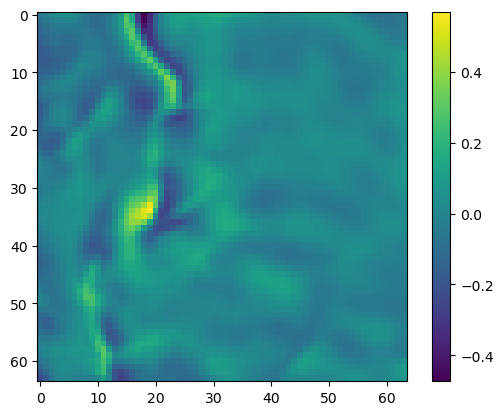

In [18]:
plt.imshow(mse_error_fields[3])
plt.colorbar()

In [19]:
basis_functions.shape

(4096, 1089)

In [20]:
mse_error_fields.shape

(856, 64, 64)

In [21]:
img_0_A = np.conj(basis_functions.T/N) @ mse_error_fields[0].ravel()[:, None] @ mse_error_fields[0].ravel()[None, :] @ basis_functions/N

In [22]:
np.diag(img_0_A)

array([5.89966471e+00+0.00000000e+00j, 7.13993660e-02+1.21430643e-16j,
       8.51989984e-02+2.74086309e-16j, ...,
       4.00551044e-07-4.79103011e-21j, 1.18231884e-06+1.79994501e-21j,
       1.93687074e-06-1.67555905e-32j])

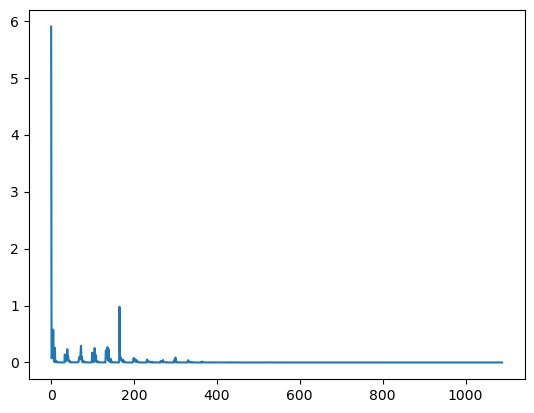

In [23]:
plt.plot(np.real(np.diag(img_0_A)))

In [24]:
img_spec_anal_params = np.zeros((mse_error_fields.shape[0], 1089))

for i in range(mse_error_fields.shape[0]):
    img_spec_anal_params[i] = np.diag(
        np.conj(basis_functions.T/N) 
        @ mse_error_fields[i].ravel()[:, None] 
        @ mse_error_fields[i].ravel()[None, :] 
        @ basis_functions/N
    )

/var/folders/k5/f6wjdcgd45n9wdxqb2g5v86m8nrvk5/T/ipykernel_62760/461754341.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  img_spec_anal_params[i] = np.diag(


In [25]:
img_spec_anal_params

array([[5.89966471e+00, 7.13993660e-02, 8.51989984e-02, ...,
        4.00551044e-07, 1.18231884e-06, 1.93687074e-06],
       [1.14908105e+01, 4.00400605e-01, 6.02584073e-01, ...,
        3.85632020e-05, 2.55962129e-05, 1.52422994e-05],
       [1.33609662e+00, 1.37883571e-01, 1.23409514e-02, ...,
        5.18957760e-05, 2.08247277e-05, 2.43884631e-06],
       ...,
       [3.31955701e+01, 9.64234836e-02, 9.04838955e-02, ...,
        4.24342649e-06, 8.60435281e-06, 4.36723421e-06],
       [9.45683691e+00, 1.67329081e-02, 3.67079693e-01, ...,
        2.44089066e-06, 2.33427401e-05, 2.77655064e-06],
       [2.43421125e+00, 3.74788732e-02, 2.78045913e-02, ...,
        3.95667755e-06, 7.19056628e-06, 1.58197683e-06]])

In [26]:
np.save('anal_sln_img_spec_params.npy', img_spec_anal_params)

Calculate std of unregularized image specific parameters

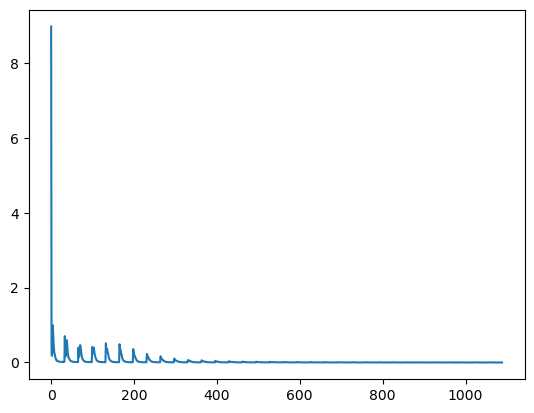

In [39]:
plt.plot((img_spec_anal_params).std(axis=0))

In [40]:
np.save('img_spec_params_std.npy', (img_spec_anal_params).std(axis=0))

# Get global 

Global solution

$s_i = (\phi^\dagger Y^T Y \phi)_{ii}$

(n_bf x N^2) (N^2 x n_img) (n_img x N^2) (N^2 x n_bf)

128

In [45]:
img_spec_anal_params.shape

(856, 1089)

/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/hgoldwyn/opt/anaconda3/envs/torch/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-5.0, 400.0)

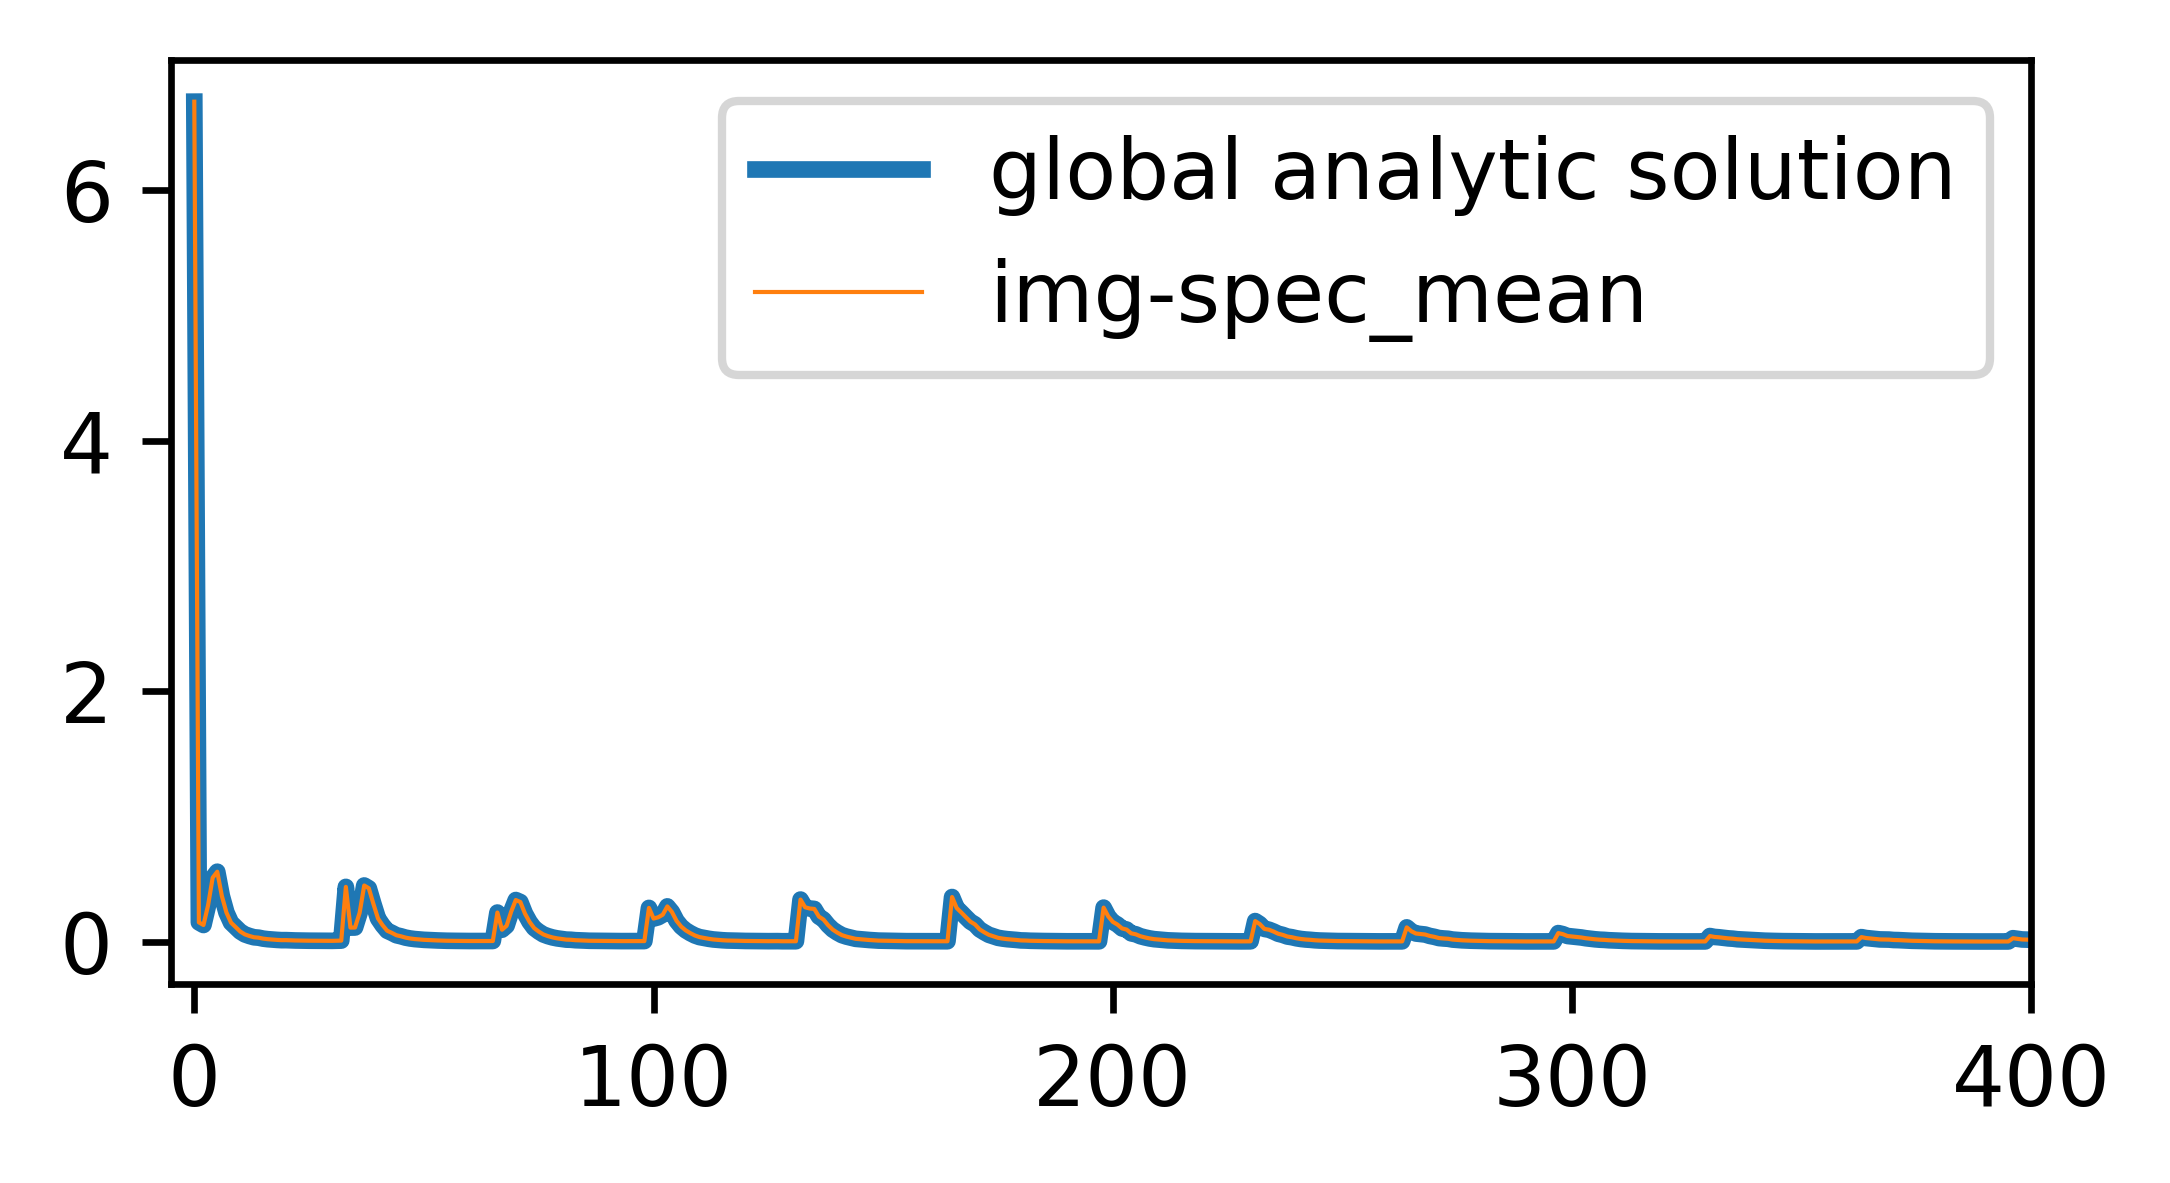

In [46]:
g_A = (
    np.matmul(
        np.matmul(
            np.matmul(
                np.conj(basis_functions.T/N),
                mse_error_fields.reshape(856, N**2).T
                ), 
            mse_error_fields.reshape(856, N**2)
            ), 
        (basis_functions/N)
        )
    )

mse_g_anal_params = np.diag(g_A) / 856

plt.figure(dpi=600, figsize=(4, 2))
plt.plot(mse_g_anal_params, lw=2, label='global analytic solution')
plt.plot(
    img_spec_anal_params.mean(axis=0), 
    lw=0.5, 
    # color='lightgray', 
    label='img-spec_mean')
plt.legend()
plt.xlim(-5, 400)

In [47]:
np.save('anal_sln_global_params.npy', mse_g_anal_params)